In [1]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 22.5 MB/s eta 0:00:00


In [2]:
pip install keras

In [3]:
pip install tensorflow

In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [5]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x780f6a525400>)

In [6]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

In [8]:
print(f"(train) len : {len(train_data)}")
print(f"(test) len : {len(test_data)}")

# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print(f"(train) len : {len(train_data)}")
print(f"(test) len : {len(test_data)}")

(train) len : 150000
(test) len : 50000
(train) len : 146183
(test) len : 49158


In [9]:
train_data['label'].value_counts()

,count
label,
0,73342
1,72841


In [10]:
test_data['label'].value_counts()

,count
label,
1,24712
0,24446


In [11]:
train_data.isnull().sum()

,0
document,1
label,0


In [12]:
test_data.isnull().sum()

,0
document,1
label,0


In [13]:
# 결측치 제거
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [14]:
# 한글과 공백 제외 리뷰 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data.head()

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [15]:
# 빈 데이터 제거
train_data = train_data[train_data['document'].str.strip().astype(bool)]
test_data = test_data[test_data['document'].str.strip().astype(bool)]

print(f"(train) len : {len(train_data)}")
print(f"(test) len : {len(test_data)}")

(train) len : 145393
(test) len : 48852


In [16]:
!apt-get install -y openjdk-11-jdk

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.environ["JAVA_HOME"] + "/bin"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk-headless openjdk-11-jre openjdk-11-jre-headless
  x11-utils
Suggested packages:
  default-jre pcscd libxt-doc openjdk-11-demo openjdk-11-source visualvm
  libnss-mdns fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libpcsclite1 libxt-dev libxtst6
  libxxf86dga1 openjdk-11-jdk openjdk-11-jdk-headless openjdk-11-jre
  openjdk-11-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 41 not upgraded.
Need to get 122 MB of archives.


In [17]:
# 토큰화
okt = Okt()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어
X_train = []

for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_train[:3]

100%|██████████| 145393/145393 [04:53<00:00, 495.49it/s]


[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [18]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [01:34<00:00, 515.79it/s]


In [19]:
# 희귀 단어 비율 확인
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어 수
rare_cnt = 0 # 등장 빈도가 3보다 작은 단어 수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도가 3보다 작은 단어의 등장 빈도의 총 합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어수 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어 수: %s'%(threshold - 1, rare_cnt))
print("희귀 단어 사용 비율:", (rare_freq / total_freq)*100)


단어수 : 43752
등장 빈도가 2번 이하인 희귀 단어 수: 24337
희귀 단어 사용 비율: 1.8715872104872904


In [20]:
# 인코딩
tokenizer = Tokenizer(total_cnt - rare_cnt + 1) # 희귀 단어 제거
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [21]:
# 희귀 단어 제거 후 다시 결측치 제거
drop_train = [i for i, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = [x for i, x in enumerate(X_train) if i not in drop_train]
y_train = [y for i, y in enumerate(y_train) if i not in drop_train]

print(len(X_train))
print(len(y_train))


145162
145162


리뷰의 평균 길이 : 10.812485361182679


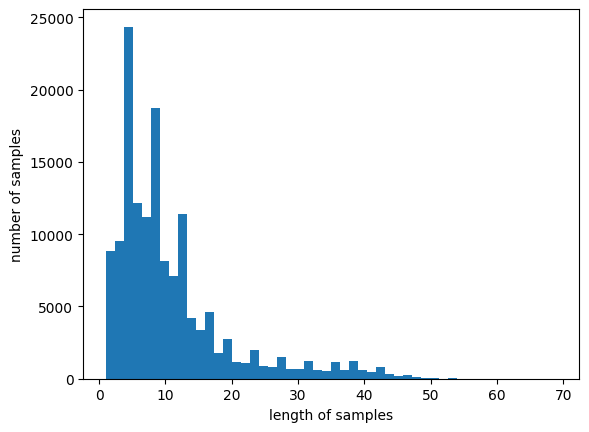

In [22]:
# 리뷰 길이 분포
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
# 길이 이하 리뷰 비율
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(20, X_train)
below_threshold_len(25, X_train)
below_threshold_len(30, X_train)

전체 샘플 중 길이가 20 이하인 샘플의 비율: 88.18836885686336
전체 샘플 중 길이가 25 이하인 샘플의 비율: 91.77884019233684
전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [24]:
# 패딩
max_len = 30
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [25]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

def build_model(hp):
    model = Sequential()

    embedding_dim = hp.Choice('embedding_dim', values=[50, 100, 200])
    model.add(Embedding(total_cnt - rare_cnt + 1, embedding_dim))
    units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    model.add(Bidirectional(LSTM(units)))
    model.add(Dense(1, activation='sigmoid'))

    # 최적화기 선택
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 데이터 양 조절 실험 + 하이퍼파라미터 튜닝
data_ratios = [0.3, 0.5, 0.7, 1.0]
results = []

for ratio in data_ratios:
    print(f"\n=== 데이터 비율: {int(ratio * 100)}% ===")

    # 데이터 샘플링
    sampled_data = train_data.sample(frac=ratio, random_state=42)
    X_train_sample = tokenizer.texts_to_sequences(sampled_data['document'])
    X_train_pad = pad_sequences(X_train_sample, maxlen=max_len)
    y_train_sample = np.array(sampled_data['label'])

    # 튜너 설정
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=3,                # 실험 횟수 조절 가능
        executions_per_trial=1,
        directory='tuner_results',
        project_name=f'sentiment_ratio_{int(ratio*100)}'
    )

    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    # 하이퍼파라미터 탐색
    tuner.search(
        X_train_pad, y_train_sample,
        epochs=5,
        validation_split=0.2,
        batch_size=64,
        callbacks=[es],
        verbose=1
    )

    # 최적 모델로 평가
    best_model = tuner.get_best_models(num_models=1)[0]
    loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
    results.append((ratio, acc))
    print(f"테스트 정확도 ({int(ratio*100)}% 데이터): {acc:.4f}")

    # 리뷰 길이별 정확도 확인
    length_bins = [0, 10, 20, 30]  # 길이 구간
    X_test_lens = np.sum(X_test > 0, axis=1)  # 패딩 제외 실제 길이

    for i in range(len(length_bins)-1):
        idx = [j for j, l in enumerate(X_test_lens) if length_bins[i] < l <= length_bins[i+1]]
        if len(idx) == 0:
           continue
        acc = np.mean((best_model.predict(X_test[idx])>0.5).flatten() == y_test[idx])
        print(f"{length_bins[i]+1}-{length_bins[i+1]} 길이 리뷰 정확도: {acc:.4f}")

Trial 3 Complete [00h 01m 27s]
val_accuracy: 0.680078387260437

Best val_accuracy So Far: 0.6810756921768188
Total elapsed time: 00h 03m 34s
테스트 정확도 (100% 데이터): 0.7710
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1-10 길이 리뷰 정확도: 0.7727
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
11-20 길이 리뷰 정확도: 0.7714
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
21-30 길이 리뷰 정확도: 0.7668


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

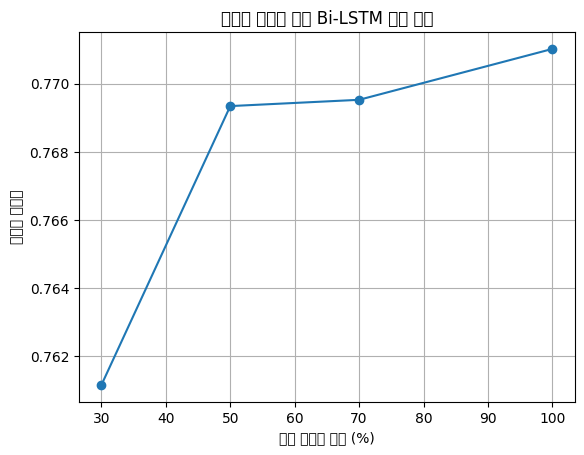

In [28]:
# 결과 시각화
import matplotlib.pyplot as plt

ratios = [int(r[0]*100) for r in results]
accuracies = [r[1] for r in results]

plt.plot(ratios, accuracies, marker='o')
plt.title('데이터 비율에 따른 Bi-LSTM 성능 변화')
plt.xlabel('학습 데이터 비율 (%)')
plt.ylabel('테스트 정확도')
plt.grid(True)
plt.show()

In [29]:
# 틀린 리뷰 샘플 확인 (오류 분석)
preds = best_model.predict(X_test)
wrong_idx = [i for i, (p, y) in enumerate(zip(preds, y_test)) if (p>0.5)!=y]
print("틀린 리뷰 샘플 예시:", test_data['document'].iloc[wrong_idx[:5]])

1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
틀린 리뷰 샘플 예시: 13                      눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다
15                                      소위 ㅈ문가라는 평점은 뭐냐
25    괜히 나올 때 어미 알 건드려서 긁어 부스름 만들었다는 분이 저 아래 보이던데 영화...
26                                  번은 봤네요어쩜 이렇게 잘만들었을까
33                                       정말진짜표현할수 없는 영화
Name: document, dtype: object


In [31]:
# 감성 예측 함수
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True)  # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords]  # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence])  # 인코딩
    pad_new = pad_sequences(encoded, maxlen=max_len)  # 패딩
    score = float(best_model.predict(pad_new))  # 예측

    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

# 예측 테스트 (최종 모델 기준)
sentences = [
    "이 영화 개꿀잼 ㅋㅋㅋ",
    "이 영화 핵노잼 ㅠㅠ",
    "연기가 정말 훌륭했어요",
    "스토리가 지루해서 잠옴",
    "개노잼이네 ㅋㅋ"
]

for s in sentences:
    sentiment_predict(s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
87.82% 확률로 긍정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
97.33% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
97.67% 확률로 긍정 리뷰입니다.



/tmp/ipython-input-2233401418.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(best_model.predict(pad_new))  # 예측


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
99.07% 확률로 부정 리뷰입니다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
98.38% 확률로 부정 리뷰입니다.

